In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import sys
sys.path.append("../")

In [3]:

from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

from src.analysis.state_space import prepare_word_trajectory_spec, prepare_state_trajectory
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.models.integrator import ContrastiveEmbeddingModel, compute_embeddings

In [4]:
# model_checkpoint = "../out/ce_model_phoneme_within_word_prefix_6_32/checkpoint-600"
# equiv_dataset_path = "../data/timit_equiv_phoneme_within_word_prefix_1.pkl"
model_checkpoint = "../out/ce_model_phoneme_6_32/checkpoint-800/"
equiv_dataset_path = "../data/timit_equiv_phoneme_1.pkl"

state_space_spec = "../out/state_space_specs/sh.pkl"

out = "../out/state_space/phoneme_6_32/sh.mp4"

In [5]:
Path(out).parent.mkdir(parents=True, exist_ok=True)

In [6]:
model = ContrastiveEmbeddingModel.from_pretrained(model_checkpoint)
model.eval()

ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=32, bias=True)
  )
)

In [7]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

In [8]:
with open(state_space_spec, "rb") as f:
    state_space_spec = pickle.load(f)

In [9]:
model_representations = compute_embeddings(model, equiv_dataset,
                                           device="cpu")
model_representations = model_representations.numpy()

  0%|          | 0/4740 [00:00<?, ?it/s]

In [10]:
pca = PCA(n_components=2)
model_representations_pca = pca.fit_transform(model_representations)

In [11]:
trajectory = prepare_state_trajectory(model_representations_pca, state_space_spec)

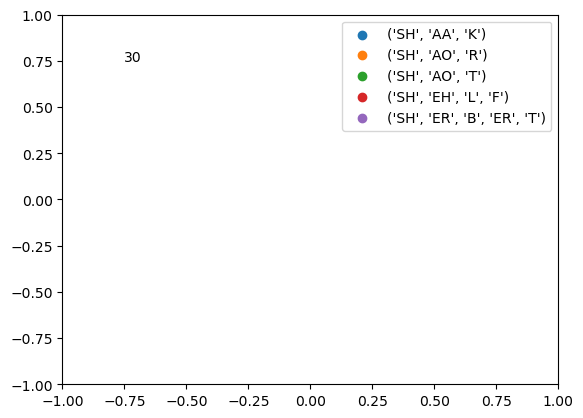

In [12]:
# Animate
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
annot_frame = ax.text(-0.75, 0.75, "-1")
scats = [ax.scatter([], []) for _ in trajectory]
ax.legend(scats, state_space_spec.labels)

def init():
    for scat in scats:
        scat.set_offsets(np.zeros((0, 2)))
    return tuple(scats)

def update(frame):
    for scat, traj_i in zip(scats, trajectory):
        scat.set_offsets(traj_i[:, frame])
    annot_frame.set_text(str(frame))
    return tuple(scats) + (annot_frame,)

# Animate by model frame
num_frames = trajectory[0].shape[1]
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=500,
                              init_func=init)
ani.save(out, writer="ffmpeg")